In [1]:
import geopandas as gpd
import pandas as pd

from polygeohasher import polygeohasher
from pygeodesy import geohash
from shapely import geometry

# Read/write .shp

In [2]:
shp = gpd.read_file('./data/natural_earth/ne_10m_admin_1_states_provinces.shp')
shp_my = shp[shp.iso_a2 == 'MY'][['name', 'geometry']]
# shp_my.to_file('./data/shapefiles/MY_geometry.shp')

In [3]:
shp_my = gpd.read_file('./data/shapefiles/MY_geometry.shp')
print(shp_my)

               name                                           geometry
0             Sabah  MULTIPOLYGON (((117.70361 4.16341, 117.70361 4...
1            Perlis  POLYGON ((100.18756 6.70796, 100.19665 6.70249...
2             Kedah  MULTIPOLYGON (((100.37766 6.52675, 100.38739 6...
3          Kelantan  POLYGON ((101.78415 5.73810, 101.80048 5.73991...
4             Perak  POLYGON ((100.97243 5.77285, 100.98002 5.76099...
5           Sarawak  MULTIPOLYGON (((115.34627 4.31377, 115.36074 4...
6      Pulau Pinang  MULTIPOLYGON (((100.40410 5.12018, 100.40903 5...
7          Selangor  MULTIPOLYGON (((101.72120 2.59585, 101.71339 2...
8   Negeri Sembilan  POLYGON ((101.98847 2.39133, 101.98878 2.39452...
9            Melaka  POLYGON ((102.48889 2.09298, 102.34864 2.14997...
10            Johor  MULTIPOLYGON (((103.64031 2.67129, 103.65211 2...
11           Pahang  POLYGON ((103.44280 4.16897, 103.44093 4.16787...
12       Terengganu  POLYGON ((102.54200 5.85476, 102.55047 5.84805...
13    

<Axes: >

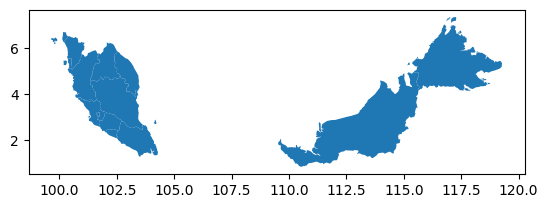

In [4]:
shp_my.plot()

# Read/write .geojson

In [5]:
# shp_my.to_file('./data/MY_geometry.geojson', driver = 'GeoJSON')

In [6]:
gdf = gpd.read_file('./data/MY_geometry.geojson')
gdf.head()

,name,geometry
0,Sabah,"MULTIPOLYGON (((117.70361 4.16341, 117.70361 4..."
1,Perlis,"POLYGON ((100.18756 6.70796, 100.19665 6.70249..."
2,Kedah,"MULTIPOLYGON (((100.37766 6.52675, 100.38739 6..."
3,Kelantan,"POLYGON ((101.78415 5.73810, 101.80048 5.73991..."
4,Perak,"POLYGON ((100.97243 5.77285, 100.98002 5.76099..."


# Get list of geohashes on a shapefile

In [7]:
df_my = polygeohasher.create_geohash_list(shp_my, 5, inner = False)
df_my.head()

,name,geohash_list
0,Sabah,"[w8gm4, w959m, w8fvc, w8g36, w8u45, w95h8, w94..."
1,Perlis,"[w1pm7, w1phy, w1pm1, w1pm8, w1pmh, w1pjr, w1p..."
2,Kedah,"[w1ps9, w1pe8, w1pdx, w1p8r, w1peh, w1p83, w1p..."
3,Kelantan,"[w2bez, w2btx, w309p, w2b63, w2bkc, w2bv2, w2b..."
4,Perak,"[w0zuf, w2bhf, w0zs1, w0xzz, w300y, w3029, w2b..."


In [8]:
df_my = df_my.explode('geohash_list').rename(columns = {'geohash_list': 'geohash'})
df_my.head()

,name,geohash
0,Sabah,w8gm4
0,Sabah,w959m
0,Sabah,w8fvc
0,Sabah,w8g36
0,Sabah,w8u45


# Convert geohashes to a shapefile

In [9]:
lat = df_my.geohash.apply(lambda x: float(geohash.decode(x)[0]))
lon = df_my.geohash.apply(lambda x: float(geohash.decode(x)[1]))
lat_delta = df_my.geohash.apply(lambda x: geohash.decode_error(x).lat)
lon_delta = df_my.geohash.apply(lambda x: geohash.decode_error(x).lon)

df_my = df_my.assign(lat = lat.values,
                     lon = lon.values,
                     lat_delta = lat_delta.values,
                     lon_delta = lon_delta.values,
                     keys = '0')
df_my.head()

,name,geohash,lat,lon,lat_delta,lon_delta,keys
0,Sabah,w8gm4,5.120,117.180,0.021973,0.021973,0
0,Sabah,w959m,5.867,117.664,0.021973,0.021973,0
0,Sabah,w8fvc,5.251,116.433,0.021973,0.021973,0
0,Sabah,w8g36,4.460,117.180,0.021973,0.021973,0
0,Sabah,w8u45,4.592,118.279,0.021973,0.021973,0


In [10]:
edges = pd.DataFrame({'edge': ['northwest', 'northeast', 'southwest', 'southeast'], 'keys': '0'})
edges

,edge,keys
0,northwest,0
1,northeast,0
2,southwest,0
3,southeast,0


In [11]:
df_my_points = pd.merge(df_my, edges, on = 'keys').drop(['keys'], axis = 1)
df_my_points.head()

,name,geohash,lat,lon,lat_delta,lon_delta,edge
0,Sabah,w8gm4,5.120,117.180,0.021973,0.021973,northwest
1,Sabah,w8gm4,5.120,117.180,0.021973,0.021973,northeast
2,Sabah,w8gm4,5.120,117.180,0.021973,0.021973,southwest
3,Sabah,w8gm4,5.120,117.180,0.021973,0.021973,southeast
4,Sabah,w959m,5.867,117.664,0.021973,0.021973,northwest


In [12]:
def calc_final_lat(edge, lat, lat_delta):
    if edge in ['northwest', 'northeast']:
        return lat + lat_delta
    elif edge in ['southwest', 'southeast']:
        return lat - lat_delta

def calc_final_lon(edge, lon, lon_delta):
    if edge in ['northeast', 'southeast']:
        return lon + lon_delta
    elif edge in ['northwest', 'southwest']:
        return lon - lon_delta

# calculate latlon of edges
final_lat = df_my_points.apply(lambda x: calc_final_lat(x['edge'], x['lat'], x['lat_delta']), axis = 1)
final_lon = df_my_points.apply(lambda x: calc_final_lon(x['edge'], x['lon'], x['lon_delta']), axis = 1)

df_my_points = df_my_points.assign(final_lat = final_lat.values,
                                   final_lon = final_lon.values)
df_my_points.head()

,name,geohash,lat,lon,lat_delta,lon_delta,edge,final_lat,final_lon
0,Sabah,w8gm4,5.120,117.180,0.021973,0.021973,northwest,5.141973,117.158027
1,Sabah,w8gm4,5.120,117.180,0.021973,0.021973,northeast,5.141973,117.201973
2,Sabah,w8gm4,5.120,117.180,0.021973,0.021973,southwest,5.098027,117.158027
3,Sabah,w8gm4,5.120,117.180,0.021973,0.021973,southeast,5.098027,117.201973
4,Sabah,w959m,5.867,117.664,0.021973,0.021973,northwest,5.888973,117.642027


In [13]:
df_my_grid = df_my_points[['name', 'geohash', 'edge', 'final_lat', 'final_lon']]
df_my_grid = df_my_grid.rename({'final_lat': 'lat', 'final_lon': 'lon'}, axis = 1)
df_my_grid = df_my_grid.drop_duplicates().reset_index(drop = True)
df_my_grid

,name,geohash,edge,lat,lon
0,Sabah,w8gm4,northwest,5.141973,117.158027
1,Sabah,w8gm4,northeast,5.141973,117.201973
2,Sabah,w8gm4,southwest,5.098027,117.158027
3,Sabah,w8gm4,southeast,5.098027,117.201973
4,Sabah,w959m,northwest,5.888973,117.642027
...,...,...,...,...,...
61235,Putrajaya,w282f,southeast,2.944027,101.732973
61236,Putrajaya,w2826,northwest,2.899973,101.689027
61237,Putrajaya,w2826,northeast,2.899973,101.732973
61238,Putrajaya,w2826,southwest,2.856027,101.689027


In [14]:
# https://geopandas.org/en/stable/gallery/create_geopandas_from_pandas.html

gdf_my = gpd.GeoDataFrame(pd.DataFrame(columns = ['geohash', 'state', 'geometry']), geometry = 'geometry')
for g in df_my_grid.geohash.unique():
    df_tmp = df_my_grid[df_my_grid.geohash == g]
    state = df_tmp.name.iloc[0]
    
    # create polygon
    p1 = geometry.Point(df_tmp[df_tmp.edge == 'northwest'].lon.iloc[0], df_tmp[df_tmp.edge == 'northwest'].lat.iloc[0])
    p2 = geometry.Point(df_tmp[df_tmp.edge == 'northeast'].lon.iloc[0], df_tmp[df_tmp.edge == 'northeast'].lat.iloc[0])
    p3 = geometry.Point(df_tmp[df_tmp.edge == 'southwest'].lon.iloc[0], df_tmp[df_tmp.edge == 'southwest'].lat.iloc[0])
    p4 = geometry.Point(df_tmp[df_tmp.edge == 'southeast'].lon.iloc[0], df_tmp[df_tmp.edge == 'southeast'].lat.iloc[0])
    
    pointList = [p1, p2, p4, p3, p1]
    poly = geometry.Polygon([[p.x, p.y] for p in pointList])
    
    # create geodataframe
    gdf_tmp = gpd.GeoDataFrame(pd.DataFrame({'geohash': [g], 'state': [state], 'geometry': [poly]}),
                               geometry = 'geometry')
    
    # append to mainframe
    gdf_my = pd.concat([gdf_my, gdf_tmp], axis = 0)
    del df_tmp, state, p1, p2, p3, p4, pointList, poly

<Axes: >

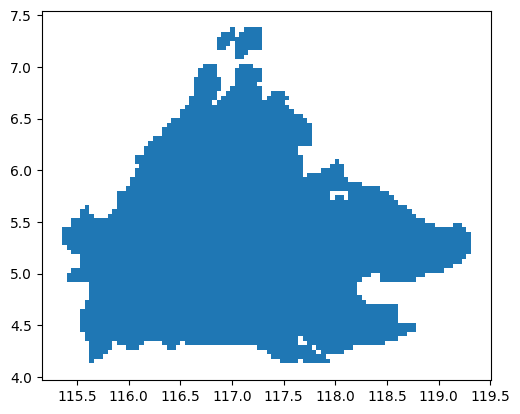

In [15]:
gdf_my[gdf_my['state'] == 'Sabah'].plot()

In [16]:
# gdf_my.to_file('./data/MY_geohash5.geojson', driver = 'GeoJSON')
# gdf_my.to_file('./data/shapefiles/MY_geohash5.shp')